In [1]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')
# Create a folder for storing Publication figures
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure4'

import _figure_parameters

linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

In [10]:
processed_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_30_Jan_2022'

df_predicted_dynamics = pd.DataFrame({})

for root, dirs, files in os.walk(processed_data_folder):
       
    for file in files:
        
        if 'PredictedDynamics' in file:
            
            df = pd.read_csv(os.path.join(root, file))
            
            df_predicted_dynamics = df_predicted_dynamics.append(df)

In [11]:
df_predicted_dynamics

,potDipole strength,activity timescale,Stable dynamics,Unstable dynamics,Predicted dynamics
0,0.500,600,Zero fixed point,[],Zero fixed point
1,0.632,600,Zero fixed point,[],Zero fixed point
2,0.763,600,Zero fixed point,[],Zero fixed point
3,0.895,600,1-Period,['Zero fixed point'],1-Period
4,1.026,600,1-Period,['Zero fixed point'],1-Period
...,...,...,...,...,...
15,2.474,750,[],"['Zero fixed point', '1-Period', '1-Period']",Aperiodic
16,2.605,750,[],"['Zero fixed point', '1-Period', '2-Period', '...",Aperiodic
17,2.737,750,[],"['Zero fixed point', '1-Period', '2-Period', '...",Aperiodic
18,2.868,750,[],"['Zero fixed point', '1-Period', '2-Period', '...",Aperiodic


<IPython.core.display.Javascript object>


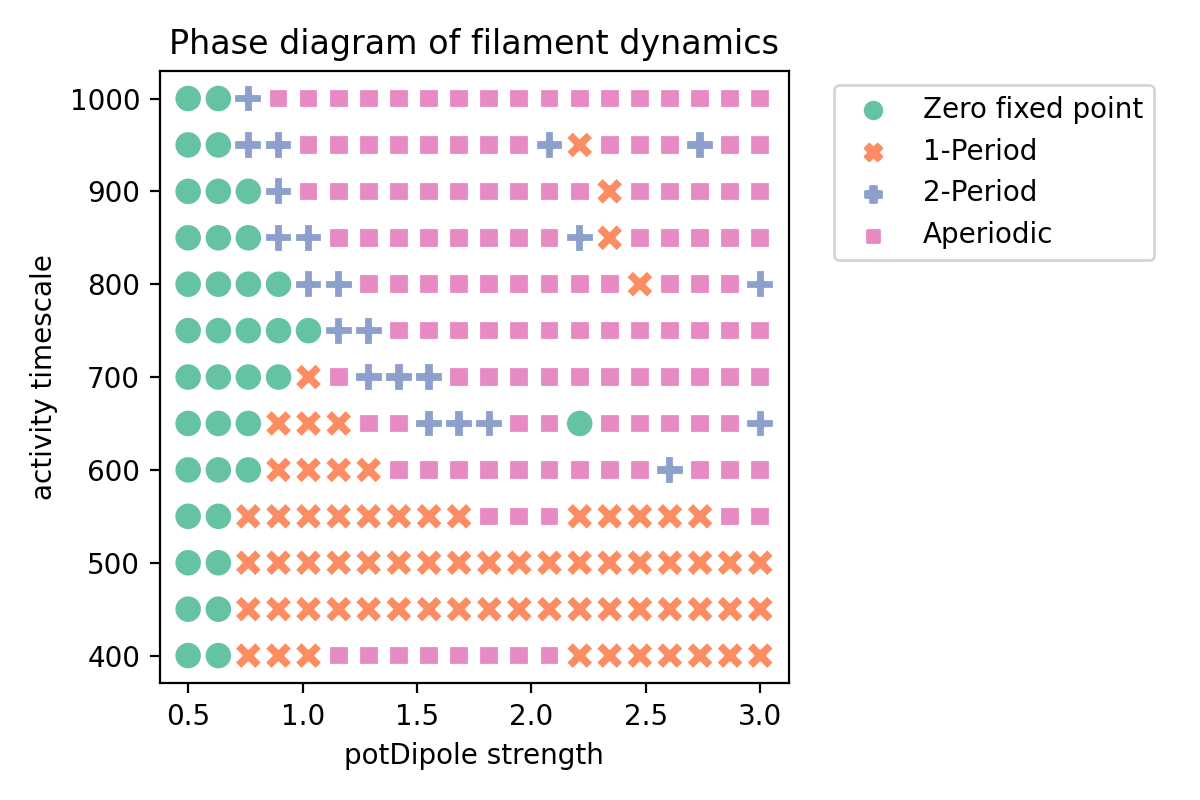

In [19]:
## Plot the predicted dynamics as a function of parameters of interest
save = True 

parameter_1 = 'potDipole strength'
parameter_2 = 'activity timescale'

title = 'Phase diagram of filament dynamics'
fig, ax = plt.subplots(figsize=(6,4))
# sns.scatterplot(x="spring constant", y=" activity time scale", hue="max unique locations", size="max unique locations",
#             sizes=(40, 400), alpha=1, palette="flare", data=df, style = "period", ax = ax,style_order = [1.0, 2.0, 4.0, 6.0, 16.0, 'aperiodic'])
sns.scatterplot(x=parameter_1, y=parameter_2, hue='Predicted dynamics',
            sizes=(400, 400), alpha=1, palette="Set2", data=df_predicted_dynamics, style = 'Predicted dynamics', 
                s= 100, hue_order = ['Zero fixed point', '1-Period', '2-Period','Aperiodic'])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title(title)
plt.tight_layout() 

if(save):

    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

## Long-term Dynamics: Full Simulation Data

In [2]:
## Load the long-term dynamics data from Full simulations
root_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweeps_diffActivityTimeScales_FINAL'
data_folders = os.listdir(root_folder)

print(data_folders)

['activityTime_500', 'activityTime_550', 'activityTime_650', 'activityTime_850', 'activityTime_800', 'activityTime_750', 'activityTime_900', 'activityTime_700', 'activityTime_600']


In [3]:
# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(os.path.join(root_folder, data_folder), topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('csv') and fileNames[0] != '.' and 'analysis' in fileNames and 'ic' not in fileNames):
                files_list.append(os.path.join(dirs,fileNames))


print('No:of files: {}'.format(len(files_list)))

# Collect all data into a single data frame
df = pd.DataFrame({})

for file in files_list:
    
    df = df.append(pd.read_csv(file))
    
print(np.unique(df['period']))

period_values = np.array([value for value in np.unique(df['period']) if not np.isnan(value)])

period_values = -np.sort(-period_values)
print(period_values)
# Assign some categorical variables to the data
df['periodic dynamics'][df['periodic dynamics']==1] = True
df['periodic dynamics'][df['periodic dynamics']==0] = False
df['period'][pd.isna(df['period'])] = 'aperiodic'
df['period'][df['simulation completed']== False] = 'Escape'

No:of files: 540
[ 1.  2.  3.  4.  6.  8. 12. 14. 15. nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
[15. 14. 12.  8.  6.  4.  3.  2.  1.]


/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
np.unique(df['filament behavior'])

array(['1-period', '2n-period', 'aperiodic', 'escape', 'no buckling',
       'odd-period'], dtype=object)

<IPython.core.display.Javascript object>


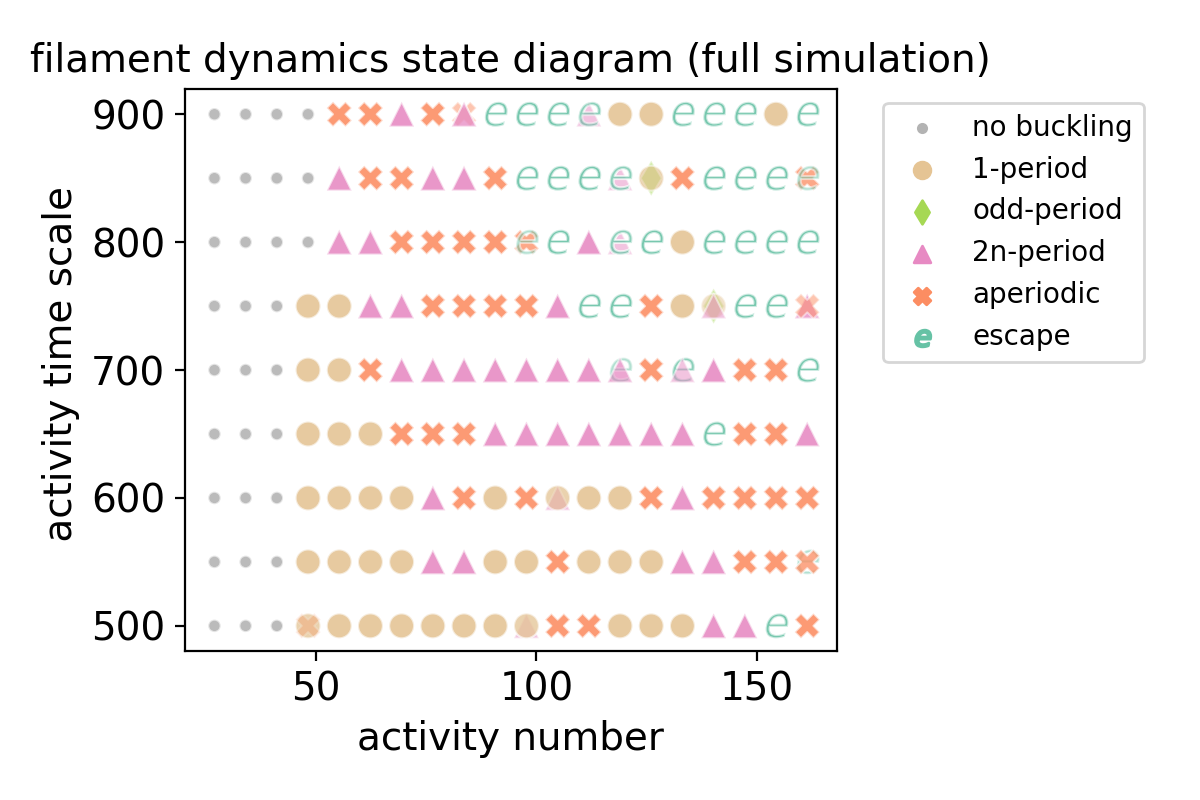

In [25]:
## Plot the predicted dynamics as a function of parameters of interest
save = True

parameter_1 = 'activity number'
parameter_2 = ' activity time scale'
hue_parameter = 'filament behavior'

# Choose a consistent color-map and markers for filament behaviors
categories = ['no buckling', '1-period', 'odd-period','2n-period','aperiodic','escape']
markers = {'no buckling':'.', '1-period':'o','odd-period':'d','2n-period':'^','aperiodic':'X','escape':'$e$'}

cmap = plt.cm.get_cmap('Set2_r', 255)
linear_array = np.linspace(0,1,len(categories))
colors={}
for ii, cat in enumerate(categories):
    
    colors[cat]=cmap(linear_array[ii])

title = 'filament dynamics state diagram (full simulation)'
fig, ax = plt.subplots(figsize=(6,4))
# sns.scatterplot(x="spring constant", y=" activity time scale", hue="max unique locations", size="max unique locations",
#             sizes=(40, 400), alpha=1, palette="flare", data=df, style = "period", ax = ax,style_order = [1.0, 2.0, 4.0, 6.0, 16.0, 'aperiodic'])
sns.scatterplot(x=parameter_1, y=parameter_2, hue = hue_parameter,
            sizes=(400, 400), alpha=0.5, palette=colors, data=df, style = hue_parameter,
                hue_order = categories, markers = markers, s= 80)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title(title)
plt.tight_layout() 

if(save):

    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

# Filament behavior vs Parameter

In [ ]:
parameter = 'activity timescale'
